In [1]:
from func import * # 复用方法
import sim # 产生模拟数据
from abocd import ABOCDetector # ABOCD检测器

import time
import numpy as np
from ruptures.detection import Pelt
import matplotlib.pyplot as plt

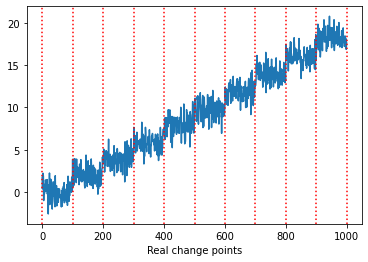

In [2]:
"""
模拟产生数据
"""
np.random.seed(0)


# 产生模拟数据
T = 1000
cps = range(100, 1100, 100)

case_name = 'normal-mean-change'
X, cps = sim.generate_data(case_name, T, cps)

plt.plot(X)
for cp in cps:
    plt.axvline(cp, c='red', ls='dotted')
plt.xlabel('Real change points')
plt.show()

In [3]:
"""
ABOCD检测流程方法
"""
def abocd_test(X, PELT_loss='l1', PELT_pen=10, W=100, D=100):
    # 进行ABOCD检测
    
    T = len(X)
    # 每个窗口中初始学习窗口大小，PELT
    alpha = int(W/4)

    # 用于存放检测到的变点
    cps_abocd = []
    
    # rt 概率
    R = np.zeros((T+1, T+1))
    R[0][0] = 0

    # 时序检测游标
    pos = 0
    while pos < T:
        # 学习窗口，PELT
        window_left = pos
        window_right = min(pos+alpha,T)
        window_learn = X[window_left: window_right]
        m = Pelt(model=PELT_loss)

        # PELT变点检测
        _cps_pelt = m.fit_predict(window_learn, pen=PELT_pen)
        # 整合到变点列表
        # pelt的最后一个变点是右端点，不需要
        cps_abocd = cp_add(cps_abocd, _cps_pelt[:-1], window_left)

        # 产生一个ABOCD检测器
        detector = ABOCDetector(window_learn)
        # 更新游标
        detect_window_right = min(pos + W, T)
        for t in range(window_right, detect_window_right):
            detector.update(X[t])

        # 记录后验概率R
        R_abocd = detector.report()
        for t in range(detect_window_right-window_right):
            le = len(R_abocd[t])
            R[t + window_right][:le] = R_abocd[t][:le]
           
        # 提取ABOCD得到的变点
        tmp_cps_abocd = get_cps(R_abocd)

        # 整合到变点列表
        cps_abocd = cp_add(cps_abocd, tmp_cps_abocd, window_right)

        if len(cps_abocd)>0:
            pos = max(cps_abocd)
        else:
            pos = min(pos + D,T-1)
    # 去重
    cps_abocd = duplicate_cps(cps_abocd)
    return R,cps_abocd

In [4]:
"""
ABOCD检测方法调用
"""
# PELT部分损失函数
loss = 'l1'
# PELT部分惩罚系数
_pen = 10
# 移动窗口大小
_W = 100
# 移动步长
_D = 100

R,cps_abocd = abocd_test(X, loss, _pen, _W, _D)
print('识别变点：', cps_abocd)

识别变点： [100, 201, 302, 402, 503, 605, 705, 802, 904, 1000]


Text(0.5, 0, 'Change points')

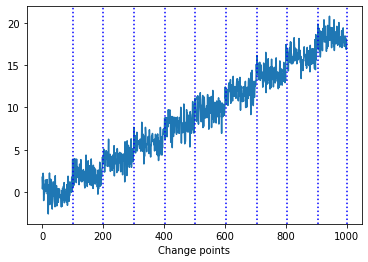

In [5]:

# 显示变点识别结果
plt.plot(X)
for cp in cps_abocd:
    plt.axvline(cp, c='blue', ls='dotted')
plt.xlabel('Change points')